In [4]:
import numpy as np
import matplotlib.pyplot as plt
from skvideo.utils import rgb2gray
import skvideo.io
from skimage import io
# from skimage import measure
from skimage.color import rgb2gray
from skimage.filters import threshold_mean  # simple mean thresholding
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
from skimage.filters import threshold_otsu
from tkinter import Tk
from tkinter.filedialog import askopenfilenames
from skimage.viewer import ImageViewer
import matplotlib.patches as mpatches
from  skimage.transform import rotate
from skimage.transform import AffineTransform, warp
from scipy.stats import linregress

C:\Users\malovich\AppData\Local\Continuum\Anaconda3\lib\site-packages\skvideo\__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
C:\Users\malovich\AppData\Local\Continuum\Anaconda3\lib\site-packages\skimage\viewer\utils\core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "


In [5]:
def get_filenames():
    """
    get filenames with graphical interface
        
    Returns
    -------
    file_list : list
        list of chosen filenames
    """
    Tk().withdraw() # we don't want a full GUI, so keep the root window from appearing
    file_list=askopenfilenames()
    return file_list

In [6]:
def rotate_image(frame, angle=0):
    """
    Rotates images if needed (for the cantilever,
    where oscillation expected only in one direction)
    
    Parameters
    -------
    frame : np-array
        grayscale image
    angle: float
        angle in deg used to rotate
        
    Returns
    -------
    angle : float
        angle in deg used for rotation
    finish: Boolean
        True if shouldn't rotate anymore
        (condition to break the loop)
    """
    print("Is this image fine for you? Chosen angle is ", angle, "degrees\n")
    plt.figure()
    plt.imshow(rotate(frame, angle), cmap=plt.cm.gray)
    plt.show()
    a = input("Choose other angle or leave blank if its ok\n")
    if a=="":
        finish=True
    else:
        angle=float(a)
        finish=False
        print("finished rotating to angle ", angle, "degrees.")
    return angle, finish

In [7]:
def threshold_centroid (image):
    """
    Using threshold, determine centroid cooordinates.
    Coordinates of the centeroid of label which has the biggest area
    (assumed to be whole light spot, not some artefact) are returned.
    
    Parameters
    -------
    image: np-array
        grayscale image
        
    Returns
    -------
    center : tuple
        tuple of center coordinates
    """
    # apply threshold
    thresh = threshold_otsu(image)
    bw = closing(image > thresh)
    # remove artifacts connected to image border
    #cleared = clear_border(bw)
    cleared = bw
    # label image regions
    label_image = label(cleared)
    image_label_overlay = label2rgb(label_image, image=image)
    centers=[]
    areas=[]
    for region in regionprops(label_image):
        # draw rectangle around segmented areas
        # minr, minc, maxr, maxc = region.bbox
        areas.append(region.area)
        center = region.centroid
        centers.append(center)
    i=areas.index(max(areas))
    return centers[i]


In [8]:
def calc_intensities(image, center_coord, Iz, Il, Isum):
    """
    Calculation of the intensity difference TP, LR, and SUM
    for the qudrants of the single image. Calculated intensities
    added to the Il, Iz, Isum lists and returned to be used over
    during the loop.
    
    Parameters
    -------
    image: np-array
        grayscale image
    center_coord: tuple
        coordinates of the center of quadrants
    Iz: list
        vertical intensity difference
    Il: list
        horizontal intensity difference
    Isum: list
        sum of intensities
        
    Returns
    -------
    Iz: list
        vertical intensity difference
    Il: list
        horizontal intensity difference
    Isum: list
        sum of intensities
    """
    I_C = np.sum(image[0:int(round(center_coord[0], 0)), 0:int(round(center_coord[1], 0))])
    I_D = np.sum(image[0:int(round(center_coord[0], 0)), int(round(center_coord[1], 0)):])
    I_B = np.sum(image[int(round(center_coord[0], 0)):, int(round(center_coord[1], 0)):])
    I_A = np.sum(image[int(round(center_coord[0], 0)):, 0:int(round(center_coord[1], 0))])
    Iz=np.append(Iz, (I_A+I_B)-(I_C+I_D))
    Il=np.append(Il, (I_A+I_C)-(I_B+I_D))
    Isum=np.append(Isum, np.sum(image))
    return Iz, Il, Isum

In [9]:
def plot_im_w_quadrants(frame, centroid):
    """
    Plot single image and showing the quadrants
    
    Parameters
    -------
    image: np-array
        grayscale image
    centroid: tuple
        coordinates of the center of quadrants
    """
    plt.figure()
    plt.imshow(frame, cmap=plt.cm.gray)
    plt.plot(centroid[1], centroid[0], "x", c="red")
    plt.axvline(x=centroid[1], c="red", linewidth=1)
    plt.axhline(y=centroid[0], c="red", linewidth=1)
    plt.show()

In [10]:
def plot_shift_curves(k_px_um, Il, Iz, Isum, x_shift, normalization=False):
    """
    Plot Intensity difference (a.u.) vs shift (in px and um)
    
    Parameters
    -------
    k_px_um: float
        px to um scale (from px size)
    Il: np.array
        LR (lateral) intensity difference signal
    Iz: np.array
        TB (vertical) intensity difference signal 
    Isum: np.array
        sum intensity signal 
    normalization: boolean
        if True, plots signal normalized over Isum
    """
    # x_shift = np.array(x_shift)
    # Il=np.array(Il)
    # Iz=np.array(Iz)
    # Isum=np.array(Isum)
    plt.figure()
    plt.grid()
    if normalization:
        plt.plot(Il/Isum, x_shift, label='lateral', linestyle='-', marker='o')
        plt.plot(Iz/Isum, x_shift, label='vertical', linestyle='-', marker='o')
        plt.xlabel('Intensity difference normalized, a.u.')
    else:
        plt.plot(Il, x_shift, label='lateral', linestyle='-', marker='o')
        plt.plot(Iz, x_shift, label='vertical', linestyle='-', marker='o')
        plt.xlabel('Intensity difference, a.u.')
    plt.title('shift in px')
    plt.ylabel('Shift, px')
    plt.legend()
    plt.figure()
    plt.grid()
    if normalization:
        plt.plot(Il/Isum, x_shift/k_px_um, label='lateral', linestyle='-', marker='o')
        plt.plot(Iz/Isum, x_shift/k_px_um, label='vertical', linestyle='-', marker='o')
        plt.xlabel('Intensity difference normalized, a.u.')
    else:
        plt.plot(Il, x_shift/k_px_um, label='lateral', linestyle='-', marker='o')
        plt.plot(Iz, x_shift/k_px_um, label='vertical', linestyle='-', marker='o')
        plt.xlabel('Intensity difference, a.u.')
    plt.title('shift in um')
    plt.ylabel('Shift, um')
    plt.legend()
    plt.show()

In [20]:
def calc_calib_line(x_shift, k_px_um, Il, Isum=None, normalization=False):
    """
    Calculate coefficient of calibration line
    
    Parameters
    -------
    x_shift: np-array
        dx shifts of image
    k_px_um: float
        px to um scale (from px size)
    Il: np.array
        LR (lateral) intensity difference signal
    Isum: np.array
        sum intensity signal 
    normalization: boolean
        if True, doing calculation for signal normalized over Isum
    """
    if normalization:
        k, b, _, _, _ = linregress(Il/Isum, x_shift/k_px_um)
    else:
        k, b, _, _, _ = linregress(Il, x_shift/k_px_um)
    if b>0:
        print('The calibration line (a.u. to um) has formula {}*x+{}'.format(round(k, 3), round(b, 3)))
    else:
        print('The calibration line (a.u. to um) has formula {}*x{}'.format(round(k, 3), round(b, 3)))
    return k, b

Let's import first frame of videofile, and show it

Importing file  Z:/LPMV/Users/Anton-Malovichko/experiments/2019/05/180519_SU8_cantilever_highfps_and_liquid/04_2500fps_5V_200Hz.avi


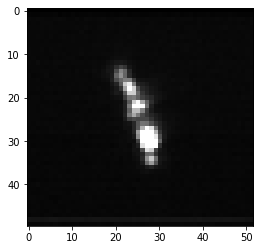

In [12]:
file = get_filenames()
file = file[0] # get just single file instead of list
print('Importing file ', file)
frame = skvideo.io.vread(file, num_frames=1) # import just first frame
frame = rgb2gray(frame[0]) # get element instead of list, make grayscale
plt.figure()
plt.imshow(frame, cmap=plt.cm.gray)
plt.show()

Compensate angle if its needed

Is this image fine for you? Chosen angle is  0 degrees



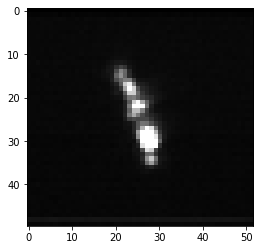

Choose other angle or leave blank if its ok
 -20


finished rotating to angle  -20.0 degrees.
Is this image fine for you? Chosen angle is  -20.0 degrees



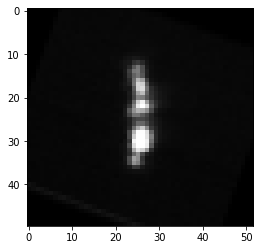

Choose other angle or leave blank if its ok
 


In [13]:
finish=False
angle=0
while finish==False:
        angle, finish=rotate_image(frame, angle)
frame=rotate(frame, angle)

*Detect center of lightspot, show quadrants:*

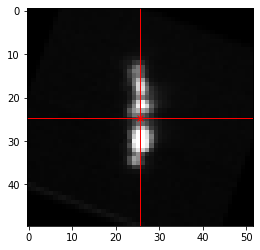

In [14]:
centroid=threshold_centroid(frame)
plot_im_w_quadrants(frame, centroid)

Demonstrate how shifted image looks like

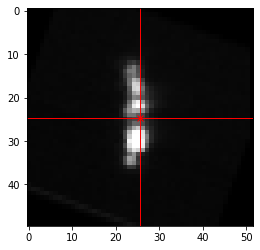

In [15]:
transform = AffineTransform(translation=(1, 0))
shifted = warp(frame, transform, mode='constant', preserve_range=True)
plot_im_w_quadrants(shifted, centroid)

Shift images along x axis

In [16]:
shifted_im = []
x_shift = np.array([0.1*dx for dx in range(1, 11)])  # generate dx value for linear shift
for dx in x_shift:
    transform = AffineTransform(translation=(dx, 0))  # shift along lateral axis
    shifted_im.append(warp(frame, transform, mode='constant', preserve_range=True))

Calculate the intensities

In [17]:
Il=np.array([])
Iz=np.array([])
Isum=np.array([])
for i in range(len(shifted_im)):
    Iz, Il, Isum = calc_intensities(shifted_im[i], centroid, Iz, Il, Isum)

Show calculated intensity difference vs displacement and get linear fit coefficients of the calibration:

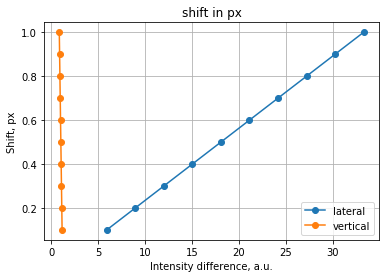

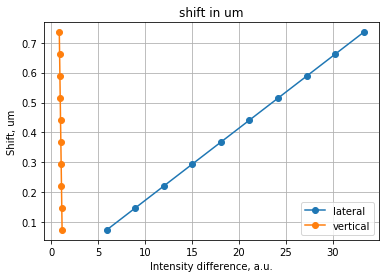

The calibration line (a.u. to um) has formula 0.024*x-0.07


In [21]:
plot_shift_curves(k_px_um=1.36, Il=Il, Iz=Iz, Isum=Isum, x_shift=x_shift, normalization=False)
k, b = calc_calib_line(x_shift=x_shift, k_px_um=1.36, Il=Il, normalization=False)